In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pinns import *

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

## Brusselator PDEs

> The Brusselator PDEs for two species are
<h3><center>$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + A - (B+1)u + u^2v$</center></h3>

<h3><center>$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v + Bu - u^2 v$</center></h3>

for diffusion constants $D_u$, $D_v$, and model parameters $A, B > 0$.
Therefore, the kinetic terms are

<h3><center>$f(u,v) = A - (B+1)u + u^2v$</center></h3>
<h3><center>$g(u,v) = Bu - u^2 v$</center></h3>

<h3><center>$u^* = A$</center></h3>
<h3><center>$v^* = \frac{B}{A}$</center></h3>



In [79]:
import pickle

#with open('./turing_Brusselator_d_t_0_01_n_32_L_0_50_T_10000.npy', 'rb') as f:
#with open('./turing_Brusselator_2_d_t_0_01_n_32_L_0_50_T_5000.npy', 'rb') as f:
#with open('./turing_Brusselator_3_d_t_0_01_n_32_L_4_00_T_1000.npy', 'rb') as f:
with open('./turing_Brusselator_4_64_64_d_t_0_01_n_64_L_4_00_T_5000.npy', 'rb') as f:    
    sol = np.load(f)
    
#with open('./turing_Brusselator_params_d_t_0_01_n_32_L_0_50_T_10000.npy', 'rb') as f:
#with open('./turing_Brusselator_params_2_d_t_0_01_n_32_L_0_50_T_5000.npy', 'rb') as f:    
#with open('./turing_Brusselator_params_3_d_t_0_01_n_32_L_4_00_T_1000.npy', 'rb') as f:
with open('./turing_Brusselator_params_4_64_64_d_t_0_01_n_64_L_4_00_T_5000.npy', 'rb') as f:
    params = pickle.load(f)

In [80]:
sol.shape, params

((3, 2, 4096),
 {'D_U': 0.01,
  'D_V': 1.0,
  'A': 1.0,
  'B': 1.5,
  'n': 64,
  'delta_t': 0.01,
  'Lx': 4.0,
  'Ly': 4.0,
  'T': 5000})

In [104]:
torch.manual_seed(42)
np.random.seed(42)

D_U = params["D_U"]#0.0016
D_V = params["D_V"]#0.0131

slice_x = slice(0, params['n'])
slice_y = slice(0, params['n'])
x = torch.linspace(0, params["Lx"], params['n'], device=dev_str)[slice_x]
y = torch.linspace(0, params["Ly"], params['n'], device=dev_str)[slice_y]
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T
# To turn the tensor to a leaf node, we detach and clone it here
data_X = data_X.detach().clone()
data_X.requires_grad = True

# data_x = torch.linspace(0, params["Lx"], 128).to(device)
# data_y = torch.linspace(0, params["Ly"], 128).to(device)
# X,Y = torch.meshgrid(x, y, indexing='ij')
# physics_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)


data_U = torch.from_numpy(sol[-1, 0, :].reshape((params['n'],params['n']))[slice_x,slice_y].flatten())
data_V = torch.from_numpy(sol[-1, 1, :].reshape((params['n'],params['n']))[slice_x,slice_y].flatten())
data_f = torch.vstack([data_U, data_V]).T.to(device)

N = x.shape[0]*y.shape[0]#params["n"]**2
domain_bounds = torch.tensor([params["Lx"], params["Ly"]]).to(device)


A = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
sampled_As = []
B = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
sampled_Bs = []




lb = torch.tensor([torch.min(x), torch.min(y)]).to(device)
ub = torch.tensor([torch.max(x), torch.max(y)]).to(device)
model = Net_dense_normalised([2, 1024, 1024, 1024, 2], lb, ub).to(device)

# optimizer = torch.optim.Adam([
#                              {'params': model.parameters()},
#                              {'params': [A, B], 'lr': 0.01}],
#                              lr=1e-4, weight_decay=0.0001)
optimizer = torch.optim.Adam([
                             {'params': model.parameters()},
                             {'params': [A, B], 'lr': 0.01}],
                             lr=1e-4, weight_decay=0.0001)
epochs = 200000
loss_data = 0.0
lambda_data = 1.0#torch.nn.Parameter(torch.ones(1, device=f"{device.type}:{device.index}"))*0.5#1.0
loss_physics = 0.0
lambda_physics = 5e-1#torch.nn.Parameter(torch.ones(1, device=f"{device.type}:{device.index}"))*0.5#5e-2


losses = np.zeros((2, epochs))

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # data loss
    # randomly select 1/4th of them
    random_indices = torch.randperm(data_X.shape[0])[:N//32]
    data_f_hat = model(data_X[random_indices,:]).squeeze()
    loss_data = torch.mean((data_f[random_indices,:] - data_f_hat)**2)


    #################################
    # physics derivatives
    # random points from U(0,1)
    # When multiplied with Lx and Ly
    #physics_X = torch.rand((N,2), requires_grad=True ,device=dev_str)*domain_bounds    
    physics_X = (ub-lb)*torch.rand((N,2), requires_grad=True ,device=dev_str) + lb
    physics_f = model(physics_X).squeeze()
    U = physics_f[:,0]
    V = physics_f[:,1]
    dxy  = torch.autograd.grad(U, physics_X, torch.ones_like(U), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacianU = dx2 + dy2
    
    dxy  = torch.autograd.grad(V, physics_X, torch.ones_like(V), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacianV = dx2 + dy2

        
    FU = torch.exp(A) - (torch.exp(B) + 1) * U + U*U*V
    FV = torch.exp(B) * U - U*U*V
    
    dudt = D_U * laplacianU + FU
    dvdt = D_V * laplacianV + FV
    ################################
    # physics loss
    # Construct the physics loss here
    loss_physics = torch.mean(dudt**2 + dvdt**2)    
    
    total_loss = (
        +lambda_data*loss_data
        +lambda_physics*loss_physics        
                    )

    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    losses[:,i] = (loss_data.item(), loss_physics.item())
    sampled_As.append(A.item())
    sampled_Bs.append(B.item())

#     a, b = torch.sum(data_X.grad**2).item(), torch.sum(physics_X.grad**2).item()
#     a2,b2 = 64*10*a, b
#     lambda_physics = a2/(a2+b2)
#     lambda_data = 1.0 - lambda_physics
#     grad_data, grad_phy = torch.sum(data_X.grad**2).item(), torch.sum(physics_X.grad**2).item()
#     loss_data, loss_phy = losses[0,i], losses[1,i]
#     w1 = loss_data**2/np.sqrt(grad_data)
#     w2 = loss_phy**2/np.sqrt(grad_phy)
#     lambda_physics = w2/(w1+w2)
#     lambda_data = 1.0 - lambda_physics
    
    
    
    if i%1000 == 0:
        print(f"Epoch: {i}")
        print(f"loss data: {losses[0,i]:.6f}, loss physics: {losses[1,i]:.6f}")
        print(f"A: {np.exp(sampled_As[-1]):.4f}, B: {np.exp(sampled_Bs)[-1]:.4f}")
#         print(f"grad_data: {grad_data:.10f}, grad_physics: {grad_phy:.10f}")
#         print(f"lambda_data: {lambda_data:.6f}, lambda_physics: {lambda_physics:.6f}")
        


Epoch: 0
loss data: 1.797155, loss physics: 10.104471
A: 2.6912, B: 2.6912
Epoch: 1000
loss data: 0.919640, loss physics: 0.015273
A: 1.0588, B: 0.8295
Epoch: 2000
loss data: 1.349707, loss physics: 0.216782
A: 1.0111, B: 0.8861
Epoch: 3000
loss data: 1.054335, loss physics: 0.257369
A: 0.9522, B: 0.8642
Epoch: 4000
loss data: 0.941895, loss physics: 0.231209
A: 0.9146, B: 0.8206
Epoch: 5000
loss data: 0.916865, loss physics: 0.236986
A: 0.8577, B: 0.7854
Epoch: 6000
loss data: 1.435601, loss physics: 0.234458
A: 0.8333, B: 0.7760
Epoch: 7000
loss data: 0.932898, loss physics: 0.219608
A: 0.7128, B: 0.6532
Epoch: 8000
loss data: 0.796131, loss physics: 0.238108
A: 0.6252, B: 0.5724
Epoch: 9000
loss data: 0.854044, loss physics: 0.267881
A: 0.5795, B: 0.5468
Epoch: 10000
loss data: 0.495472, loss physics: 0.240755
A: 0.5696, B: 0.5426
Epoch: 11000
loss data: 0.538852, loss physics: 0.305994
A: 0.5567, B: 0.5517
Epoch: 12000
loss data: 0.674156, loss physics: 0.220504
A: 0.5426, B: 0.532

Epoch: 106000
loss data: 0.001819, loss physics: 0.033321
A: 0.9925, B: 1.4680
Epoch: 107000
loss data: 0.001310, loss physics: 0.045231
A: 0.9975, B: 1.4654
Epoch: 108000
loss data: 0.001999, loss physics: 0.016784
A: 0.9950, B: 1.4727
Epoch: 109000
loss data: 0.004666, loss physics: 0.016469
A: 0.9922, B: 1.4670
Epoch: 110000
loss data: 0.001269, loss physics: 0.010136
A: 0.9912, B: 1.4720
Epoch: 111000
loss data: 0.001665, loss physics: 0.013686
A: 0.9936, B: 1.4621
Epoch: 112000
loss data: 0.003008, loss physics: 0.008833
A: 0.9893, B: 1.4645
Epoch: 113000
loss data: 0.002492, loss physics: 0.010251
A: 0.9939, B: 1.4737
Epoch: 114000
loss data: 0.000659, loss physics: 0.004638
A: 0.9939, B: 1.4759
Epoch: 115000
loss data: 0.001137, loss physics: 0.008570
A: 0.9932, B: 1.4725
Epoch: 116000
loss data: 0.001421, loss physics: 0.009201
A: 0.9950, B: 1.4760
Epoch: 117000
loss data: 0.001661, loss physics: 0.013477
A: 0.9917, B: 1.4773
Epoch: 118000
loss data: 0.003015, loss physics: 0.0

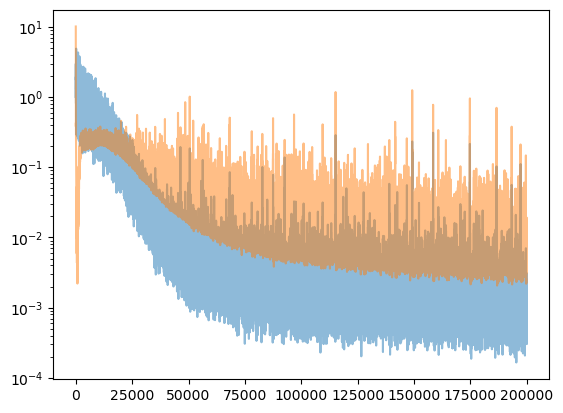

0.9988379526445024 1.4873420335307164 189267


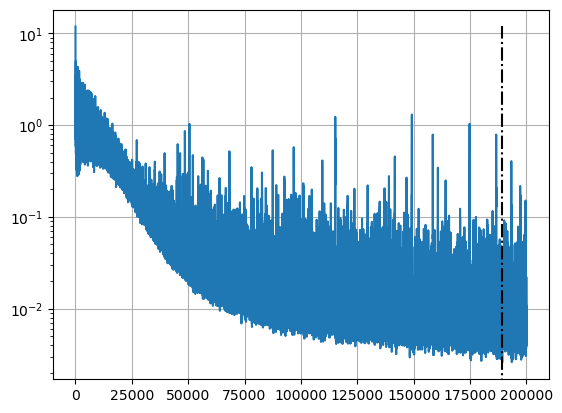

In [105]:
plt.plot(losses[0,:], alpha=.5)
plt.plot(losses[1,:], alpha=.5)
plt.yscale('log'); plt.show()
plt.plot(np.sum(losses, axis=0))

index = np.argmin(np.sum(losses, axis=0)[20:])
print(np.exp(sampled_As[index]), np.exp(sampled_Bs[index]), index)
plt.yscale('log'); 
plt.vlines(index, 0, np.max(np.sum(losses, axis=0)), color='black', linestyles='-.');plt.grid();

plt.show()

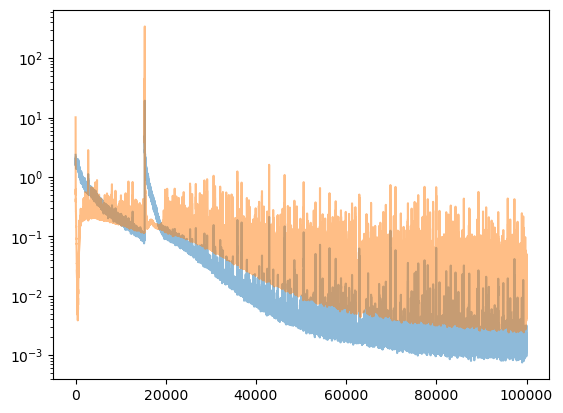

0.9936884502172757 1.474769364230471 99363


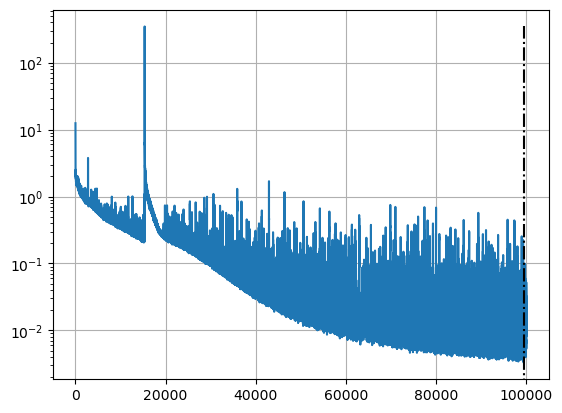

In [102]:
plt.plot(losses[0,:], alpha=.5)
plt.plot(losses[1,:], alpha=.5)
plt.yscale('log'); plt.show()
plt.plot(np.sum(losses, axis=0))

index = np.argmin(np.sum(losses, axis=0)[20:])
print(np.exp(sampled_As[index]), np.exp(sampled_Bs[index]), index)
plt.yscale('log'); 
plt.vlines(index, 0, np.max(np.sum(losses, axis=0)), color='black', linestyles='-.');plt.grid();

plt.show()

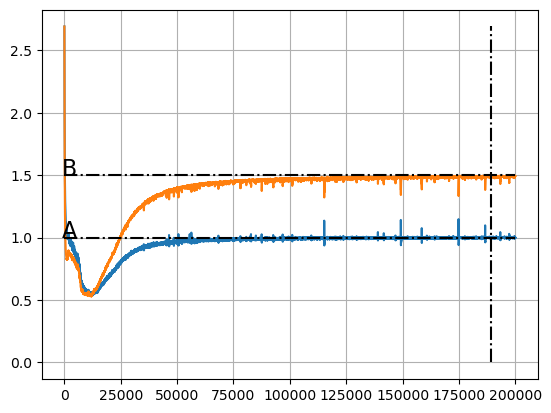

0.9978114238917565 1.4938246491251876
0.9987216887566647 0.005078219446567461 1.4856943605302053 0.009417745914692043


In [107]:
plt.plot(np.exp(sampled_As))
plt.plot(np.exp(sampled_Bs))
plt.hlines(params["A"], 0, epochs, linestyles="-.", color="black")
plt.annotate("A", (-1000, params["A"]), (-1000, params["A"]), fontsize=16)
plt.hlines(params["B"], 0, epochs, linestyles="-.", color="black")
plt.annotate("B", (-1000, params["B"]), (-1000, params["B"]), fontsize=16)
plt.vlines(index, 0, 
           max(np.max(np.exp(sampled_As)),np.max(np.exp(sampled_Bs)))
          ,color='black', linestyles='-.');plt.grid()
plt.show()
print(np.exp(sampled_As[-1]), np.exp(sampled_Bs[-1]))
print(np.mean(np.exp(sampled_As[150000:])),np.std(np.exp(sampled_As[150000:])),
      np.mean(np.exp(sampled_Bs[150000:])), np.std(np.exp(sampled_Bs[150000:])))

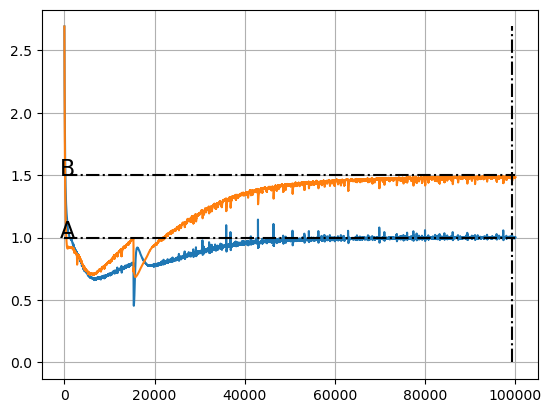

1.0019467961853739 1.4826779074291183
0.9930891191842744 0.008602119304498435 1.4640330291883181 0.02031020353974436


In [103]:
plt.plot(np.exp(sampled_As))
plt.plot(np.exp(sampled_Bs))
plt.hlines(params["A"], 0, epochs, linestyles="-.", color="black")
plt.annotate("A", (-1000, params["A"]), (-1000, params["A"]), fontsize=16)
plt.hlines(params["B"], 0, epochs, linestyles="-.", color="black")
plt.annotate("B", (-1000, params["B"]), (-1000, params["B"]), fontsize=16)
plt.vlines(index, 0, 
           max(np.max(np.exp(sampled_As)),np.max(np.exp(sampled_Bs)))
          ,color='black', linestyles='-.');plt.grid()
plt.show()
print(np.exp(sampled_As[-1]), np.exp(sampled_Bs[-1]))
print(np.mean(np.exp(sampled_As[50000:])),np.std(np.exp(sampled_As[50000:])),
      np.mean(np.exp(sampled_Bs[50000:])), np.std(np.exp(sampled_Bs[50000:])))

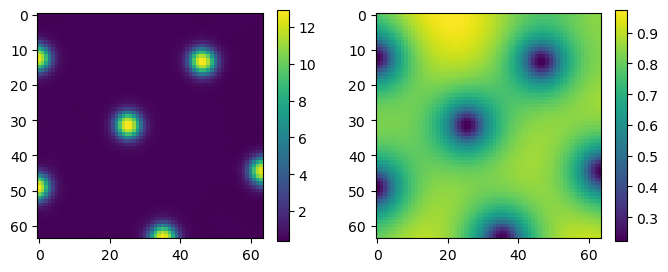

In [108]:
solution = model(data_X).cpu().detach()
U_hat = solution[:, 0].reshape((params["n"], params["n"]))
V_hat = solution[:, 1].reshape((params["n"], params["n"]))
index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(U_hat)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(V_hat)
plt.colorbar(shrink=.75)
plt.show()

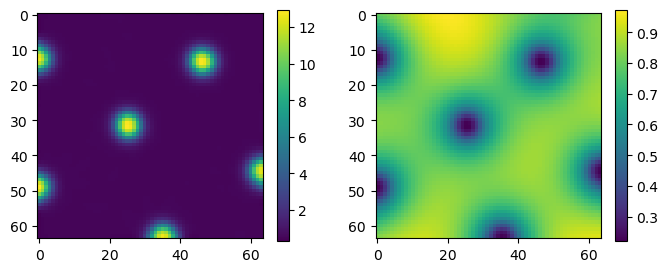

In [99]:
solution = model(data_X).cpu().detach()
U_hat = solution[:, 0].reshape((params["n"], params["n"]))
V_hat = solution[:, 1].reshape((params["n"], params["n"]))
index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(U_hat)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(V_hat)
plt.colorbar(shrink=.75)
plt.show()

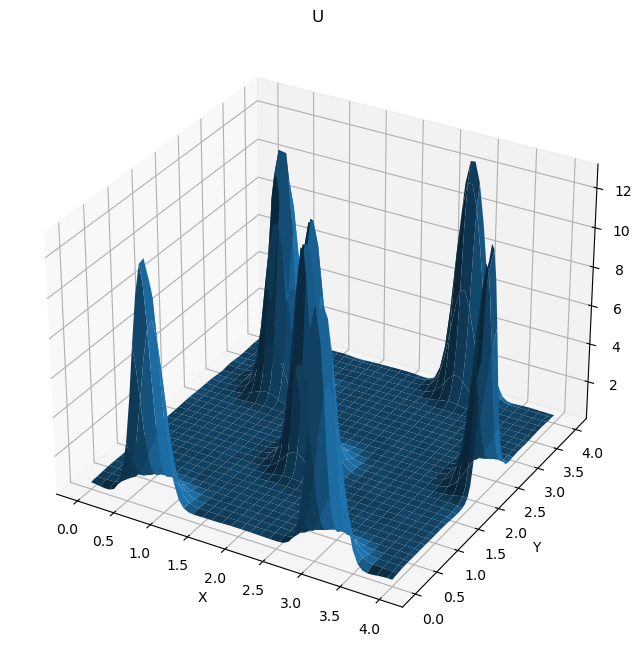

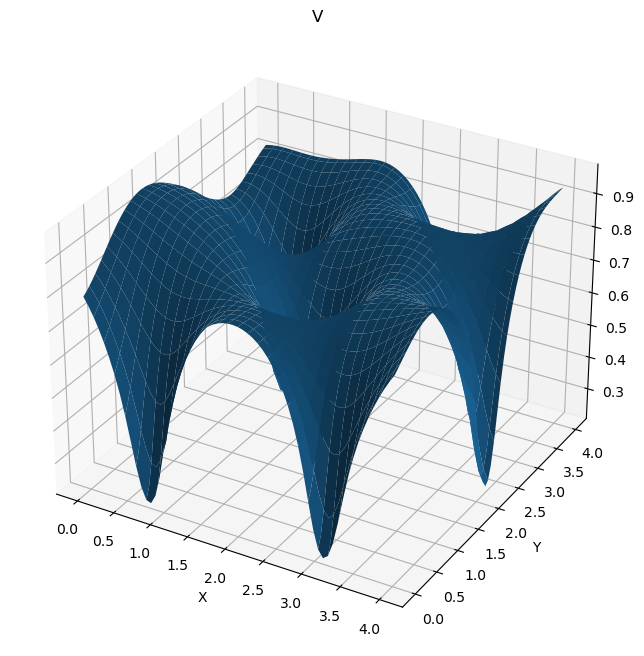

In [85]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X.cpu().detach(), Y.cpu().detach(), U_hat)
plt.title("U"); plt.xlabel("X"); plt.ylabel("Y")    
plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X.cpu().detach(), Y.cpu().detach(), V_hat)
plt.title("V"); plt.xlabel("X"); plt.ylabel("Y")    
plt.show()

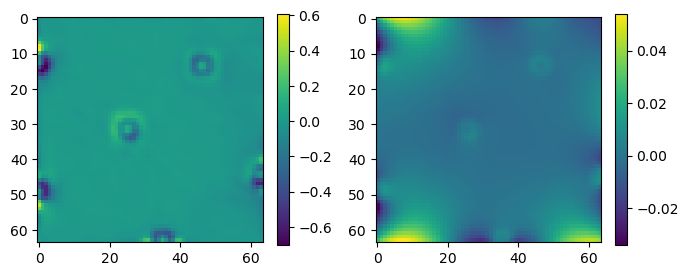

In [109]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(U_hat-sol[-1, 0, :].reshape((params["n"], params["n"]))[slice_x, slice_y])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(V_hat-sol[-1, 1, :].reshape((params["n"], params["n"]))[slice_x, slice_y])
plt.colorbar(shrink=.75)
plt.show()

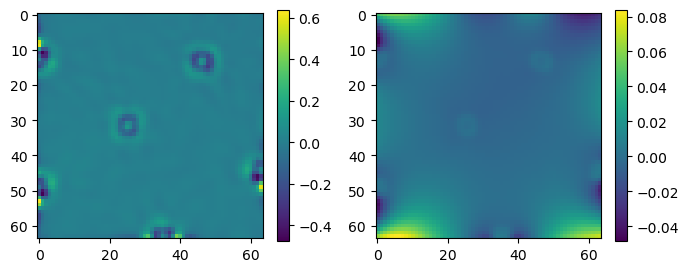

In [100]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(U_hat-sol[-1, 0, :].reshape((params["n"], params["n"]))[slice_x, slice_y])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(V_hat-sol[-1, 1, :].reshape((params["n"], params["n"]))[slice_x, slice_y])
plt.colorbar(shrink=.75)
plt.show()

In [96]:
FU2 = torch.exp(A) - (11 + 1) * U + U*U*V
FV2 = 11 * U - U*U*V

tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(39.5547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4004, device='cuda:0', grad_fn=<MeanBackward0>)


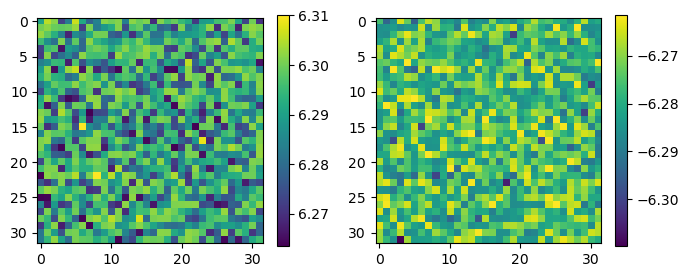

In [97]:
print(torch.mean((params["D_U"]*laplacianU - FU)**2),
      torch.mean((params["D_V"]*laplacianV- FV)**2))
print(torch.mean((params["D_U"]*laplacianU - FU2)**2),
      torch.mean((params["D_V"]*laplacianV- FV2)**2))

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.array((params["D_U"]*laplacianU - FU2).cpu().detach()).reshape((32,32)))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(np.array((params["D_V"]*laplacianV- FV2).cpu().detach()).reshape((32,32)))
plt.colorbar(shrink=.75)
plt.show()

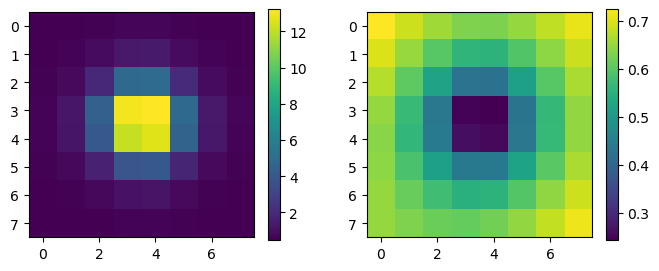

In [58]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(sol[-1, 0, :].reshape((32,32))[2:10,6:14])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(sol[-1, 1, :].reshape((32,32))[2:10,6:14])
plt.colorbar(shrink=.75)
plt.show()

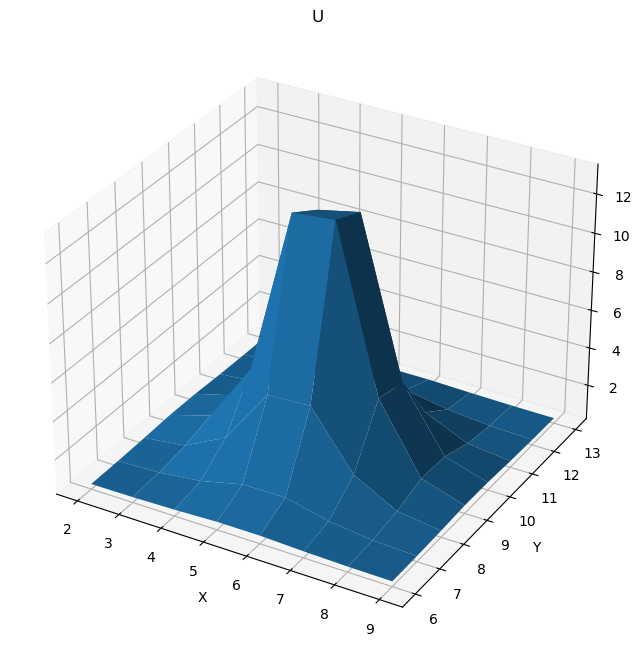

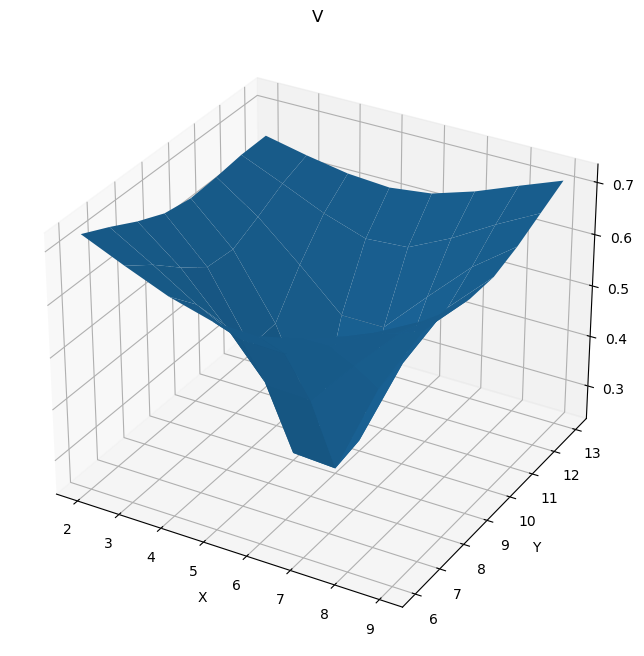

In [59]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
X_text, Y_test = np.meshgrid(np.arange(2,10,1), np.arange(6,14,1))
ax.plot_surface(X_text, Y_test, sol[-1, 0, :].reshape((32,32))[2:10,6:14])
plt.title("U"); plt.xlabel("X"); plt.ylabel("Y")    
plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X_text, Y_test, sol[-1, 1, :].reshape((32,32))[2:10,6:14])
plt.title("V"); plt.xlabel("X"); plt.ylabel("Y")    
plt.show()

In [69]:
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from local_utils import *

from turing.classic_models import create_Brusselator
from pde_solvers.cn import *

In [70]:
delta_t = 0.01
Lx = Ly = 4.0
D_U, D_V = 0.01, 1.0#0.0016, 0.0135#0.01, 1.0
n = (32, 32)
#n = (64, 64)
model = RD_2D_1st_Order(Ds=[D_U, D_V], delta_t=delta_t, Lx=Lx, Ly=Ly, 
                        Ix=n[0], Jy=n[1],
                        boundary_condition=Neumann_Boundary_2D
                        #boundary_condition=Periodic_Boundary_2D
                        # boundary_condition=Diritchlet_Boundary_2D
                       )

/end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [71]:
A, B = np.mean(np.exp(sampled_As[50000:])), np.mean(np.exp(sampled_Bs[50000:]))

Brusselator=create_Brusselator(A,B)


cu = sol[-1, 0, :].reshape((32,32))
cv = sol[-1, 1, :].reshape((32,32))

steps = 100000
sol2 = model.integrate([cu.flatten(), cv.flatten()] ,Brusselator, steps,record_steps=steps//2)

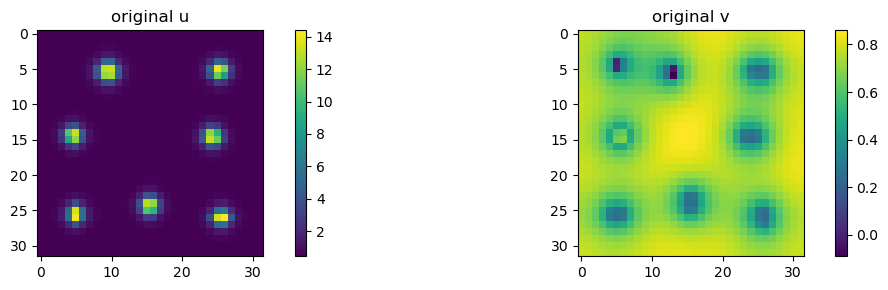

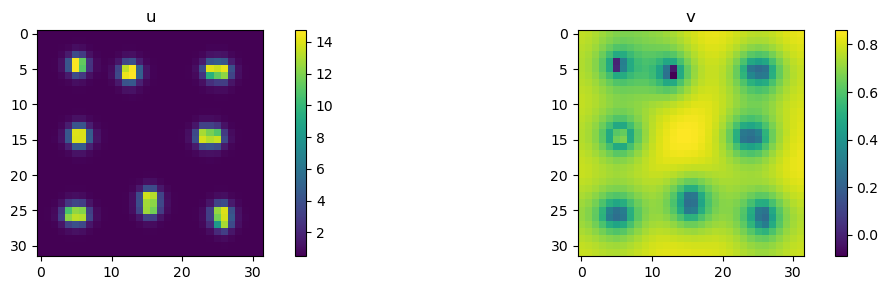

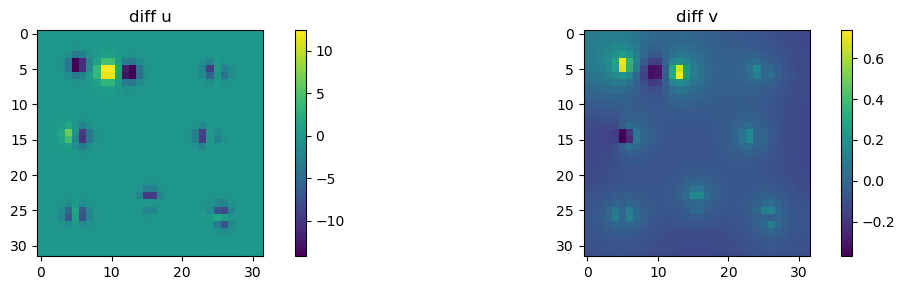

In [78]:
plot_n_im([sol[-1, 0, :].reshape((n[0],n[1])), sol2[-1, 1, :].reshape((n[0],n[1]))], 
          ["original u", "original v"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([sol2[-1, 0, :].reshape((n[0],n[1])), sol2[-1, 1, :].reshape((n[0],n[1]))], 
          ["u", "v"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([(sol[-1, 0, :]-sol2[-2, 0, :]).reshape((n[0],n[1])), 
           (sol[-1, 1, :]-sol2[-2, 1, :]).reshape((n[0],n[1]))], 
          ["diff u", "diff v"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()